<a href="https://colab.research.google.com/github/anupmerkap87/Capstone/blob/main/Visual_Factory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 3.9 MB/s 


In [ ]:
import scipy.io
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd
import os
import glob
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu


In [ ]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
ints = list(range(1,129))
ch_names = ['E'+str(int) for int in ints]
sampling_freq = 250

# the EEG data were filtered (bandpass = 1–40 Hz) using a Hamming windowed Sinc FIR filter

l_freq = 1
h_freq = 40

# Electrode position of interest
Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}

ele_pos = [35,103,23,123,32,121,21,8,69,82,51,91,44,107,57,95]
ele = list(Electrode_map.values())

In [ ]:
def extract_data(file):
  mat = scipy.io.loadmat(file)
  key = list(mat.keys())
  data = key[3]
  a_mat = mat[data]
  return a_mat

In [ ]:
def extract_raw_array(a_mat):
  info = mne.create_info(ch_names= ch_names,
                       ch_types='eeg', verbose=None,
                       sfreq=sampling_freq)
  simulated_raw = mne.io.RawArray(a_mat[:-1,:], info)
  simulated_raw.set_montage(montage)
  return simulated_raw 

In [ ]:
def raw_trunc(simulated_raw):
  simulated_raw_truc = simulated_raw.filter(l_freq,h_freq,method = 'fir',fir_window = 'hamming')
  return simulated_raw_truc

Creating RawArray with float64 data, n_channels=128, n_times=75113
    Range : 0 ... 75112 =      0.000 ...   300.448 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 8.192 (s)


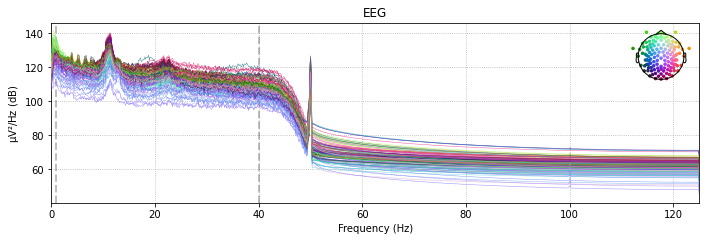

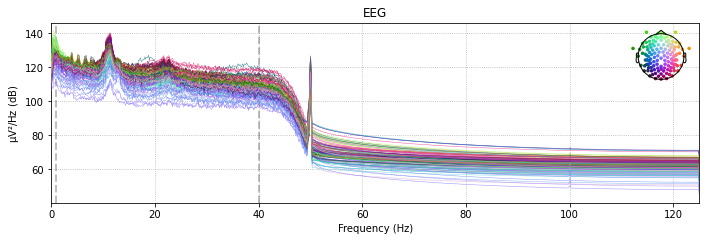

In [ ]:
data_file = raw_trunc(extract_raw_array(extract_data('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015/02030019_rest 20151230 1314.mat')))
data_file.plot_psd()

In [ ]:
result = data_file.get_data()
df = pd.DataFrame(data = result.T, columns = ch_names)

In [ ]:
df.shape

(75113, 128)

In [ ]:
df = df.filter(items=ele)
df.reset_index(inplace = True)
df = df.rename(columns = {'index': 'Time'})
df.iloc[14999:22999,:]


,Time,E36,E104,E24,E124,E33,E122,E22,E9,E70,E83,E52,E92,E45,E108,E58,E96
14999,14999,0.150743,3.627250,-2.878769,2.529760,0.062227,6.444695,-2.911951,4.043621,14.233641,16.918842,6.971999,7.719582,13.965422,10.504252,18.876954,11.190445
15000,15000,1.511180,4.016285,-0.740820,4.861475,1.320167,9.851840,1.317268,8.642656,11.763237,16.233007,5.349601,6.858992,10.381836,10.643921,16.389238,11.183712
15001,15001,2.216588,4.439300,0.217155,6.632119,2.143104,12.038238,3.764195,11.172553,5.965133,11.782996,2.589762,6.871009,4.343546,11.265393,9.818669,13.205594
15002,15002,1.753634,5.011442,0.000397,7.624884,2.620005,12.935801,4.215725,11.443822,-0.878168,5.277399,-0.152528,7.864213,0.295079,12.479422,2.193388,16.501838
15003,15003,0.578057,5.533894,0.212577,8.431058,3.371990,13.145601,4.402196,11.425924,-6.155927,-0.243652,-2.226803,8.352787,0.717253,12.787702,-3.552514,18.059262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22994,22994,-6.338459,-0.999543,-0.077699,-1.735880,-0.015080,-6.300667,-4.650801,-15.080016,-10.999786,-10.221687,-9.088973,-6.253017,-1.048478,-8.664181,-14.534066,-17.821535
22995,22995,-5.695450,-1.436948,-0.201048,-0.440230,0.717850,-4.556946,-5.035802,-14.182034,-16.191542,-14.446692,-10.519615,-9.847832,-6.762846,-11.320772,-18.447501,-22.792798
22996,22996,-4.235281,-1.006646,0.726171,0.863027,1.374976,-1.669102,-4.326623,-11.542662,-20.873100,-18.303144,-10.559072,-10.384863,-12.915699,-10.419019,-20.909572,-22.482257
22997,22997,-2.861622,-0.209240,2.739830,2.009160,1.991869,0.835065,-1.379049,-7.880444,-24.373130,-21.866090,-9.772921,-8.998748,-16.701752,-7.569007,-22.168384,-19.613334


In [ ]:
df2 = df.melt(id_vars=["Time"], 
        var_name="Electrode", 
        value_name="Value")

In [ ]:
df2['Value'] = pd.to_numeric(df2['Value'])

In [ ]:
z_data = df2.iloc[14999:22999,:]
z = z_data.Value
x = z_data.Time
y = z_data.Electrode
#sh_0, sh_1 = z.shape
#x, y = np.linspace(0, 1, 8000), np.linspace(0, 1, 17)
fig = go.Figure(data=[go.Surface(z=z)])
fig.update_layout(title='EEG', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
df3 = pd.read_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Resting_Summary_limited.csv')

In [ ]:
final_patient_resting = pd.DataFrame()

for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='mat':
        print("File name ",file,"Position ",index)
        fin = str(folder)+"/"+str(file)
        matA = extract_data(fin)
        raw_array = extract_raw_array(matA)
        raw_trunct = raw_trunc(raw_array)
        result = raw_trunct.get_data()
        df = pd.DataFrame(data = result.T, columns = ch_names)
        df = df.filter(items=ele)
        df.reset_index(inplace = True)
        df = df.rename(columns = {'index': 'Time'})
        df['patient'] = file[:8]
        df = df.iloc[14999:22999,:]
        final_patient_resting = pd.concat([final_patient_resting,df],axis = 0)




File name  02010002rest 20150416 1017..mat Position  0
Creating RawArray with float64 data, n_channels=128, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)

File name  02010004rest 20150427 1335..mat Position  1
Creating RawArray with float64 data, n_channels=128, n_times=75339
    Range : 0 ... 75338 =      0.000 ...   301.352 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass fil

In [ ]:
final_patient_resting.shape

(424000, 18)

In [ ]:

df_demo = pd.read_excel('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx')
df_demo =  df_demo.iloc[: , :-2]


df_gender = pd.get_dummies(df_demo["gender"])
df_demo = pd.concat((df_demo, df_gender), axis=1)
df_demo = df_demo.drop(["gender"], axis=1)
df_demo = df_demo.drop(["M"], axis=1)
df_demo = df_demo.rename(columns={"F": "Gender"}) #Female = 1; Male = 0

df_type = pd.get_dummies(df_demo["type"])
df_demo = pd.concat((df_demo, df_type), axis=1)
df_demo = df_demo.drop(["type"], axis=1)
df_demo = df_demo.drop(["HC"], axis=1) #MDD = 1; HC = 0


In [ ]:
df_demo.head()

,subject id,age,education（years）,PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI,Gender,MDD
0,2010002,18,12,23,77,-143,31,18,12,1,1
1,2010004,25,19,12,53,-44,38,13,11,1,1
2,2010005,20,16,19,49,-3,28,11,5,0,1
3,2010006,42,16,16,59,-30,40,12,9,0,1
4,2010008,42,12,17,66,-71,44,18,13,0,1


In [ ]:
final_patient_resting['patient'] = pd.to_numeric(final_patient_resting['patient'])
final_patient_resting_30sec = final_patient_resting

In [ ]:
df2 = final_patient_resting_30sec.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")
df2.head()

,Time,patient,Electrode,Value
0,14999,2010002,E36,-4.198719
1,15000,2010002,E36,-4.063483
2,15001,2010002,E36,-3.619494
3,15002,2010002,E36,-3.686508
4,15003,2010002,E36,-4.321619


In [ ]:
df2['patient'] = pd.to_numeric(df2['patient'])

In [ ]:
df_fin = pd.merge(df2, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')
df_fin.head()

,Time,patient,Electrode,Value,subject id,MDD
0,14999,2010002,E36,-4.198719,2010002,1
1,15000,2010002,E36,-4.063483,2010002,1
2,15001,2010002,E36,-3.619494,2010002,1
3,15002,2010002,E36,-3.686508,2010002,1
4,15003,2010002,E36,-4.321619,2010002,1


In [ ]:
def plot_sensors_correlation(df9, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_healthy = pd.pivot_table(df9[df9['MDD'] == 0], values='Value', index='patient', columns='Electrode').corr()

                                          
    correlations_MDD = pd.pivot_table(df9[df9['MDD'] == 1], values='Value', index='patient', columns='Electrode').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Healty Group', fontsize=14)
    mask = np.zeros_like(correlations_healthy, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_healthy, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Patients with MDD', fontsize=14)
    mask = np.zeros_like(correlations_MDD, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_MDD, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    

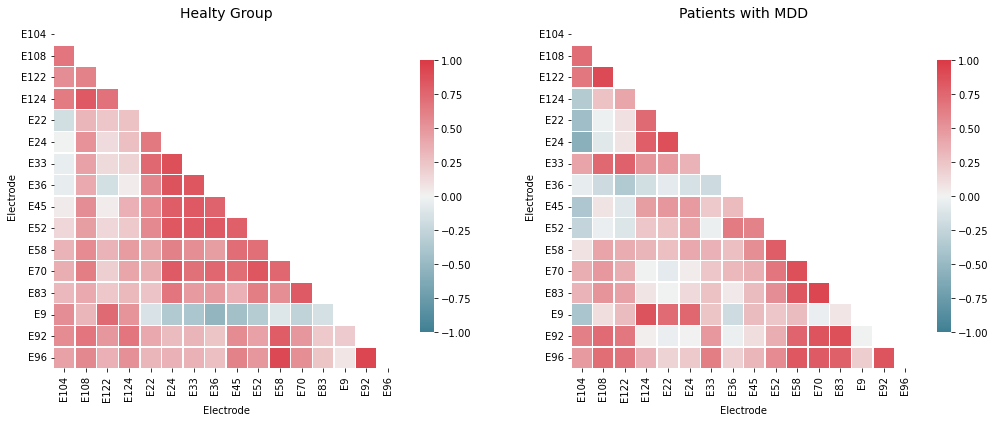

In [ ]:
plot_sensors_correlation(df_fin, threshold_value=.8)

In [ ]:
def file_importer(path='/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/02010002erp 20150416 1131.raw',type =1):
  """
  Inputs:
  path = Location of the raw file
  type = 1 / 0 indicating raw or mat format
  Outputs:
  Returns the .raw object for EEG
  """
  if type == 1:
    df = mne.io.read_raw_egi(path,verbose=True)
    #Delete the bad signal that we identified
    df.drop_channels('E129')
    #Just set the montage - Though the research institution provided us the montage file, 
    #there are numerous challenges importing the file as the matlab native format is not set in the 
    #mne package. As a result, we will be utilizing make_standard_montage file present in the mne library -- 
    #As the machine that was used is related to 'GSN_HydroCel-129'. However, kindly ensure that we are 
    #deleting the dead signal E129
  else:
    ch_names = ['E'+str(i+1) for i in range(128)]
    sampling_freq = 250
    mat = scipy.io.loadmat(path)
    key = list(mat.keys())
    data = key[3]
    a_mat = mat[data]
    info = mne.create_info(ch_names= ch_names,
                       ch_types='eeg', verbose=None,
                       sfreq=sampling_freq)
    df = mne.io.RawArray(a_mat[:-1,:], info)

  df.set_montage(montage)
  #df = df.pick_channels(ch_names = list(Electrode_map.values()))
  #df.plot_psd()
  return df    

In [ ]:
def channel_explorer(df):
  """
  Input
  df - EEG Waveform from the simulated experiment
  Output
  returns -
  Happy waveform, Sad waveform, Fear waveform 
  as a tuple
  """
  #Select only the STIM channels (channels that stores impulses)
  list_channels = df.copy().pick_types(meg=False, stim=True).ch_names
  #Get the data in numpy format
  temp = pd.DataFrame(df.copy().pick_types(meg=False, stim=True).get_data().T)
  #Set the column names as per the incoming electrode positions
  temp.columns = list_channels
  temp.reset_index(inplace = True)

  #initialization
  df_happy = pd.DataFrame()
  df_sad = pd.DataFrame()
  df_fear = pd.DataFrame()

  #Loop to go through each emotion and output the values
  for col in temp.columns:
    if col!='index':
      if col in ['fcue', 'fdot','ffix', 'fisi', 'fwrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_fear = pd.concat([df_fear,te],axis = 1)
      if col in ['hcue', 'hdot', 'hfix', 'hisi', 'hwrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_happy = pd.concat([df_happy,te],axis = 1)
      if col in ['scue', 'sdot', 'sfix', 'sisi', 'swrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_sad = pd.concat([df_sad,te],axis = 1)
  event_dict = {'fear':(np.min(df_fear,axis = 1)[1],np.max(df_fear,axis = 1)[0]),
                'sad':(np.min(df_sad,axis = 1)[1],np.max(df_sad,axis = 1)[0]),
                'happy':(np.min(df_happy,axis = 1)[1],np.max(df_happy,axis = 1)[0])}
  print(event_dict)
  #Check for sequence
  sequence_order = np.argsort([i[0] for i in list(event_dict.values())])
  vals = list(event_dict.keys())
  sequence = [vals[i] for i in sequence_order]
  print(sequence)
  print(event_dict[sequence[0]][1])
  print(event_dict[sequence[1]][0])
  print(event_dict[sequence[1]][1])
  print(event_dict[sequence[2]][0])
  #Check for overlaps
  val = 0
  if (event_dict[sequence[0]][1]>event_dict[sequence[1]][0]) or (event_dict[sequence[1]][1]>event_dict[sequence[2]][0]):
    val = 1
    print("Problem with event spacings - Kindly check")
  fear_raw = df.copy().crop(tmin=event_dict['fear'][0]/250,tmax=event_dict['fear'][1]/250)
  happy_raw = df.copy().crop(tmin=event_dict['happy'][0]/250,tmax=event_dict['happy'][1]/250)
  sad_raw = df.copy().crop(tmin=event_dict['sad'][0]/250,tmax=event_dict['sad'][1]/250)
  return fear_raw,happy_raw,sad_raw      

In [ ]:
final_patient_happy = pd.DataFrame()
final_patient_sad = pd.DataFrame()
final_patient_fear = pd.DataFrame()

for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='raw':
        print("File name ",file,"Position ",index)
        fin = str(folder)+"/"+str(file)
        df = file_importer(fin)
        fear,happy,sad = channel_explorer(df)

        fear_df = fear.get_data()
        fear_col = fear.ch_names
        df_fear = pd.DataFrame(data = fear_df.T, columns = fear_col)
        df_fear = df_fear.filter(items=ele)
        df_fear.reset_index(inplace = True)
        df_fear = df_fear.rename(columns = {'index': 'Time'})
        df_fear['patient'] = file[:8]
        df_fear = df_fear.iloc[14999:22999,:]
        final_patient_fear = pd.concat([final_patient_fear,df_fear],axis = 0)

        happy_df = happy.get_data()
        happy_col = happy.ch_names
        df_happy = pd.DataFrame(data = happy_df.T, columns = happy_col)
        df_happy = df_happy.filter(items=ele)
        df_happy.reset_index(inplace = True)
        df_happy = df_happy.rename(columns = {'index': 'Time'})
        df_happy['patient'] = file[:8]
        df_happy = df_happy.iloc[14999:22999,:]
        final_patient_happy = pd.concat([final_patient_happy,df_happy],axis = 0)

        sad_df = sad.get_data()
        sad_col = sad.ch_names
        df_sad = pd.DataFrame(data = sad_df.T, columns = sad_col)
        df_sad = df_sad.filter(items=ele)
        df_sad.reset_index(inplace = True)
        df_sad = df_sad.rename(columns = {'index': 'Time'})
        df_sad['patient'] = file[:8]
        df_sad = df_sad.iloc[14999:22999,:]
        final_patient_sad = pd.concat([final_patient_sad,df_sad],axis = 0)
        
        


File name  02010008_erp(n) 20150619 1709.raw Position  0
Reading EGI header from /content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/02010008_erp(n) 20150619 1709.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {SESS} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
{'fear': (134154, 200861), 'sad': (301, 67161), 'happy': (67353, 133947)}
['sad', 'happy', 'fear']
67161
67353
133947
134154
File name  02010011erp 20150625 1545.raw Position  5
Reading EGI header from /content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/02010011erp 20150625 1545.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
{'fear': (590

In [ ]:
df_fear = final_patient_fear.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")

df_fear['patient'] = pd.to_numeric(df_fear['patient'])
df_fin_fear = pd.merge(df_fear, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')



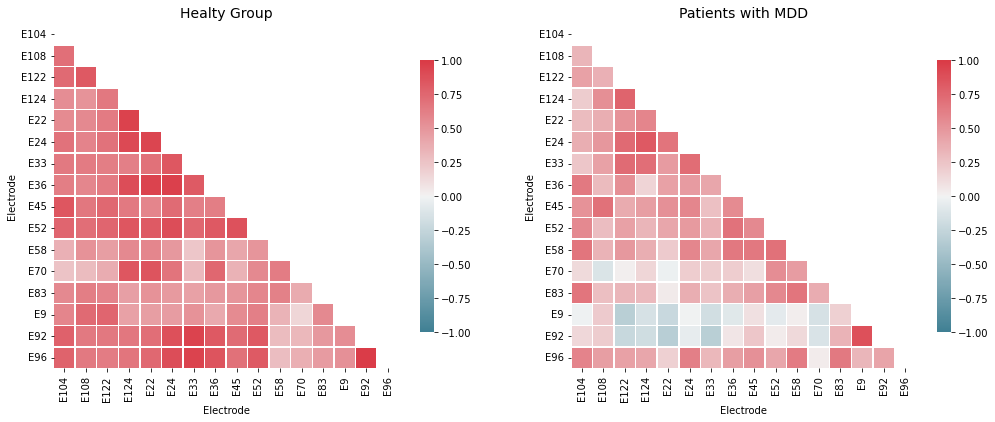

In [ ]:
plot_sensors_correlation(df_fin_fear, threshold_value=.97)

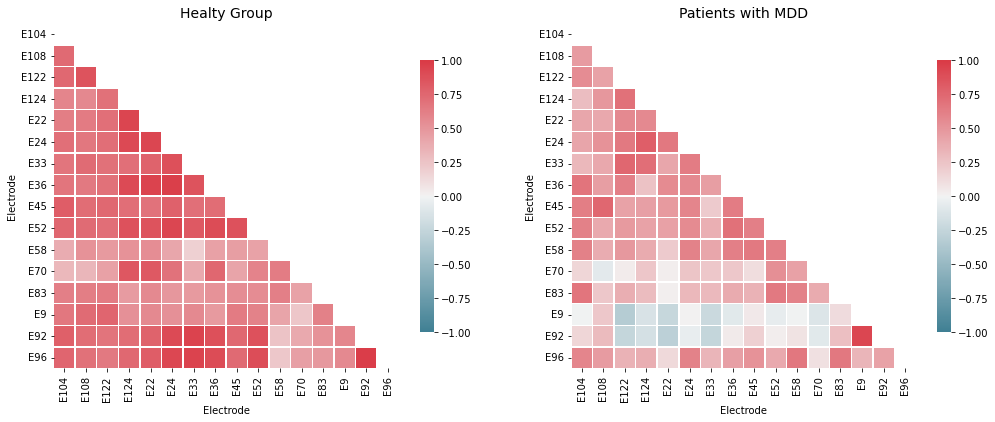

In [ ]:

df_sad = final_patient_sad.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")

df_sad['patient'] = pd.to_numeric(df_sad['patient'])
df_fin_sad = pd.merge(df_sad, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')
plot_sensors_correlation(df_fin_sad, threshold_value=.97)

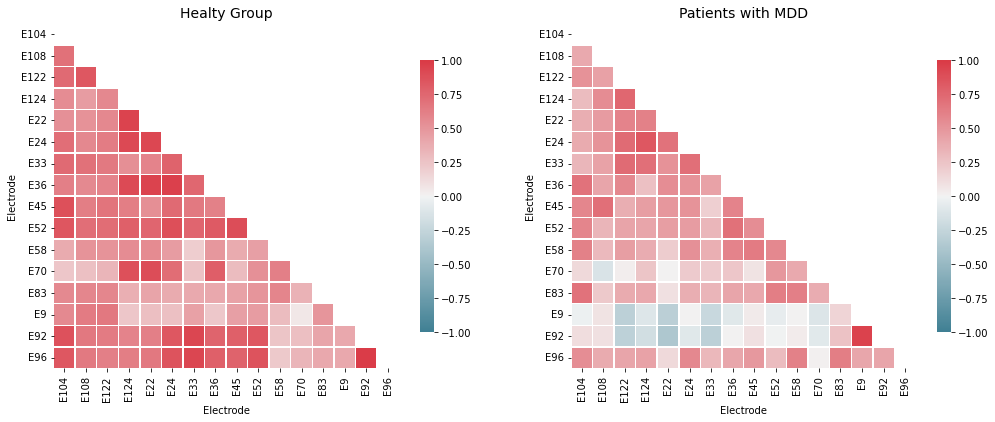

In [ ]:
df_happy = final_patient_happy.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")

df_happy['patient'] = pd.to_numeric(df_happy['patient'])
df_fin_happy = pd.merge(df_happy, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')
plot_sensors_correlation(df_fin_happy, threshold_value=.97)